#  <span style='color:blue'> Handwritten Digit Classification Using the MNIST Dataset – A Convolutional Neural Network Approach </span>
**Author :** [Bitewulign Kassa Mekonnen](https://scholar.google.com/citations?user=SHPCjakAAAAJ&hl=en)<br>
**Instructor :** Hossein Pourmodheji <br>
**Lab Assistant :** Sebastian<br>
**Date created :**  2024/10/10<br>
**Last modified :** 2024/10/21  <br>

**Objective:** To apply various preprocessing and machine learning techniques to 
classify handwritten digits from the MNIST (alternative link) dataset without using 
deep learning methods. <br>

**Project Description :** The MNIST dataset is a collection of 70,000 grayscale images of handwritten digits (0-9), 60,000 train and 10,000 test datasets. Each image is 28x28 pixels. The goal of this project is to build a machine learning model that can accurately classify these images into the correct digit categories. <br>


<span style='color:red; font-size: 12px;'> <b>Note:</b>  This project is developed to fulfill the requirements of the Bridge to Cloud Computing and Big Data course. </span>

# Import the necessary libraries

In [1]:
import warnings
import sys
import os, shutil
warnings.filterwarnings('ignore')
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
#U-net model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Conv2D,
                                     MaxPooling2D,
                                     Dense,
                                     Flatten,
                                     Input,
                                     BatchNormalization,
                                     Dropout)
from tensorflow.keras.callbacks import (EarlyStopping, 
                             ModelCheckpoint)
from tensorflow.keras.utils import plot_model

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
                             confusion_matrix,
                             roc_curve, auc,
                             classification_report)
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from sklearn.metrics import precision_recall_curve, average_precision_score

<center>
<b><span style="font-size: 36px;">Part 1: Data Preprocessing</span></b>
</center>


1. Data Loading:

    ➢ Use fetch_openml from scikit-learn to load the MNIST dataset.
    
    ➢ Explore the dataset to understand its structure (number of samples, feature dimentions, etc.)
    
2. Data Normalization:

    ➢ Normalize the pixel values to a range of 0 to 1 to ensure uniformity in the input data scale. 
    
3. Data Visualization: 

    ➢ Visualize a subset of images using matplotlib to get a sense of what the handwritten digits look like. 
    
4. Dimentionality Reduction (optional):

    ➢ Apply PCA to reduce the dimentionality of the dataset while preserving most of the variance.

In [2]:
# 1. Data Loading
mnist = fetch_openml('mnist_784', as_frame=False)
X_data, Y_data = mnist["data"], mnist['target'].astype(np.uint8)
#X_data= X_data.reshape(X_data.shape[0], 28, 28)

print(f'X shape: {X_data.shape}, Y shape : {Y_data.shape}')

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=10000, random_state=42)
print(f'X-train shape : {X_train.shape}, X-test shape : {X_test.shape}, Y-train shape : {y_train.shape},  Y-test shape : {y_test.shape}')

X shape: (70000, 784), Y shape : (70000,)
X-train shape : (60000, 784), X-test shape : (10000, 784), Y-train shape : (60000,),  Y-test shape : (10000,)


## Prepare the data for TensorFlow

We've already loaded our data and split it into training and validation datasets. However, we need to do some further data preparation so that our data will work correctly with TensorFlow. Specifically, we need to set the data type of our features to 32-bit floating point numbers, and specify that the labels represent categorical classes rather than numeric values.

In [3]:
# Set data types for float features
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Set data types for categorical labels
Y_train = y_train.copy()
y_train = utils.to_categorical(y_train, 10)
#y_test = utils.to_categorical(y_test)
print('Ready...')

Ready...


### Data Normalization: 
➢ Normalize the pixel values to a range of 0 to 1 to ensure uniformity in the 
input data scale. 

In [4]:
x_train = X_train / 255
x_test = X_test / 255

####  3. Data Visualization: 
➢ Visualize a subset of images using matplotlib to get a sense of what the 
handwritten digits look like. 
Lets print some more training examples to get the feeling ogf how the digits were written

In [5]:

# 3. Data Visualization
def plot_sample_images(X, y, n_samples=10, figs = (10,10)):
    plt.figure(figsize=figs)
    # Calculate the grid size
    rows_cols = int(np.ceil(np.sqrt(n_samples)))
    for i in range(n_samples):
        plt.subplot(rows_cols, rows_cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"L: {y[i]}", color = 'blue')
        plt.axis('off')
    plt.show()

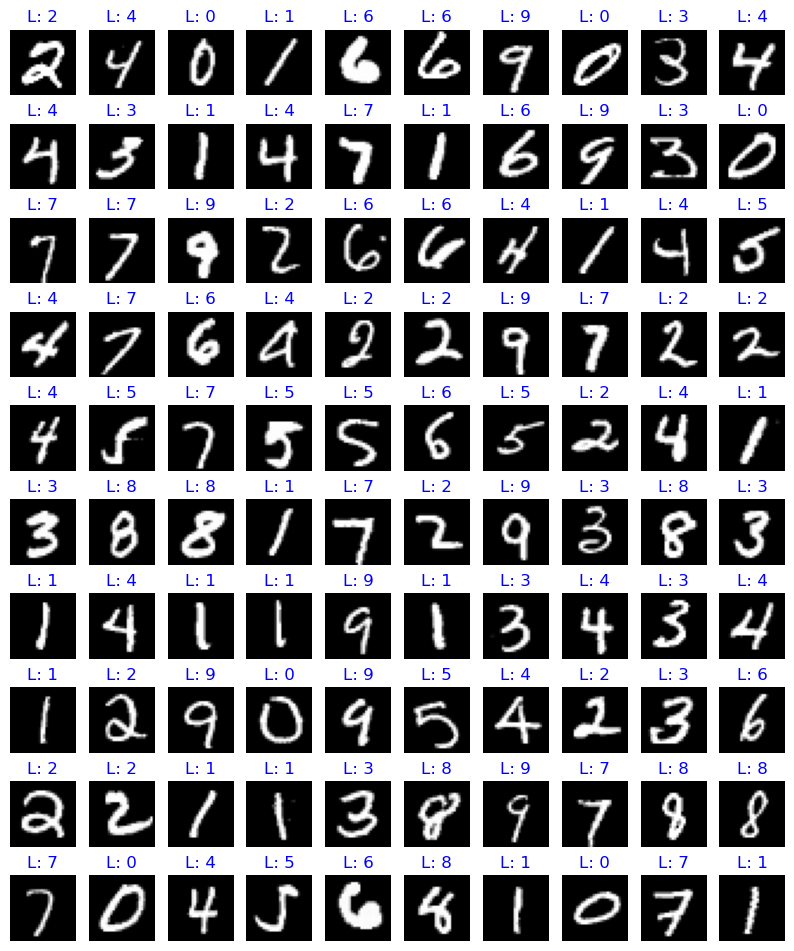

In [6]:
plot_sample_images(x_train, Y_train, n_samples = 100, figs = (10,12))

<center>
<b><span style="font-size: 36px;">Part 2: Machine Learning</span></b>
</center>

1.  Model Selection:<br>
     ➢ Choose CNN (Convolutional Neural Network) for the model training.
     
     
2. Model Training:<br>
    ➢ Split the dataset into training and testing sets. (60,000 train and 10,000 test)
    
    ➢ Train each model on the training set.
    
3. Model Evaluation:

    ➢ Evaluate each model’s performance on the testing set using metrics such as accuracy, precision, recall, and F1-score.
    
    ➢ Use a confusion matrix to visualize the performance of each model.

In [7]:
# # Define input layers
# inputs = Input((28 * 28, ))
# # Define hidden layers
# hidden_layer_1 = Dense(128, activation='relu')(inputs)
# hidden_layer_2 = Dense(64, activation='relu')(hidden_layer_1)
# #hidden_layer_3 = Dense(16, activation='relu')(hidden_layer_2)
# outputs = Dense(units=10, activation= 'softmax',)(hidden_layer_2)
# model = Model(inputs=[inputs], outputs=[outputs])
# model.summary()
model = Sequential()
model.add(Dense(512, input_dim=784, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(128, input_dim=128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(64, input_dim=128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(32, input_dim=64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(10, input_dim=32, activation='softmax'))

print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 10)                3

2024-10-15 22:06:36.241439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-15 22:06:36.241568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-15 22:06:36.244206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-15 22:06:36.244310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-15 22:06:36.244394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [8]:
# plot_model(model, show_shapes=True, show_layer_names=True,)

## Compile the model and Train the model

In [9]:
adam_optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=adam_optimizer,loss= 'categorical_crossentropy',metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpointer = ModelCheckpoint('models/dnn-project-training-digits-classifier.h5', verbose=1, save_best_only=True)

training_history = model.fit(x_train,
                             y_train,
                             epochs=100,
                             validation_split = 0.1,
                             callbacks=[early_stop, checkpointer])

Epoch 1/100
 170/1688 [==>...........................] - ETA: 1s - loss: 2.7566 - accuracy: 0.3623

2024-10-15 22:06:37.326073: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1654/1688 [============================>.] - ETA: 0s - loss: 1.2635 - accuracy: 0.8174
Epoch 00001: val_loss improved from inf to 0.77264, saving model to models/dnn-project-training-digits-classifier.h5
1688/1688 [==============================] - 2s 1ms/step - loss: 1.2550 - accuracy: 0.8194 - val_loss: 0.7726 - val_accuracy: 0.9383
Epoch 2/100
1635/1688 [============================>.] - ETA: 0s - loss: 0.7398 - accuracy: 0.9319
Epoch 00002: val_loss improved from 0.77264 to 0.61624, saving model to models/dnn-project-training-digits-classifier.h5
1688/1688 [==============================] - 2s 970us/step - loss: 0.7378 - accuracy: 0.9321 - val_loss: 0.6162 - val_accuracy: 0.9528
Epoch 3/100
1669/1688 [============================>.] - ETA: 0s - loss: 0.5996 - accuracy: 0.9482
Epoch 00003: val_loss improved from 0.61624 to 0.52068, saving model to models/dnn-project-training-digits-classifier.h5
1688/1688 [==============================] - 2s 948us/step - loss: 0.5988 - accuracy: 0.


# Get class probability scores for the later use

In [10]:
## Save to csv history
hist_dic = {'train_loss': training_history.history['loss'],
           'valid_loss': training_history.history['val_loss'],
           'train_acc': training_history.history['accuracy'],
           'valid_acc':training_history.history['val_accuracy']
           }
hist_df = pd.DataFrame(hist_dic)

In [11]:
hist_df

,train_loss,valid_loss,train_acc,valid_acc
0,1.255020,0.772640,0.819389,0.938333
1,0.737832,0.616240,0.932093,0.952833
2,0.598781,0.520683,0.948241,0.962167
3,0.506462,0.450077,0.957889,0.965333
4,0.439702,0.396901,0.964352,0.970500
...,...,...,...,...
95,0.107422,0.139429,0.992593,0.981000
96,0.107801,0.136516,0.992407,0.981667
97,0.107350,0.138547,0.992111,0.980167
98,0.106036,0.131773,0.993037,0.983000


In [12]:
hist_df.to_csv('results/dnn-history-training-digits-classifier.csv',  index = False)#header = header,

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


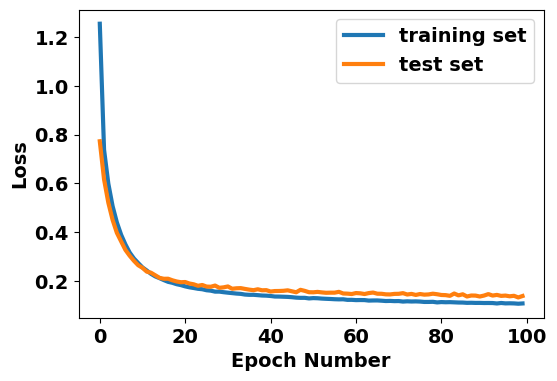

In [13]:
## Summarize history for loss
import matplotlib.font_manager as font_manager
plt.figure(figsize=(6,4))
plt.plot(training_history.history['loss'], label='training set', lw =3)
plt.plot(training_history.history['val_loss'], label='test set', lw = 3)
# plt.plot( np.argmin(valid_hist), np.min(valid_hist), marker="x", color="r", label="best model")
plt.xlabel("Epoch Number", fontweight = 'bold', fontsize = 14)
plt.ylabel("Loss",fontweight = 'bold', fontsize = 14)
plt.xticks(fontweight = 'bold', fontsize = 14)
plt.yticks(fontweight = 'bold', fontsize = 14)
font = font_manager.FontProperties(family='Times New Roman', weight='bold', style='normal', size=14)
plt.legend(prop = font)
plt.show()

In [14]:

## If custom used
loaded_model = load_model('models/dnn-project-training-digits-classifier.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 10)                3

<center>
<b><span style="font-size: 36px;">Part 3: Reporting</span></b>
</center>

1.  Results Compilation:

     ➢ Compile the results from each model into a report.
     
     ➢ Include visualizations such as ROC curves and Precision-Recall curves.
     
2. Discussion:

     ➢ Discuss the performance of each model and the impact of preprocessing techniques.
     
     ➢ Provide insights on which model worked best and hypothesize why.

### Import Testing data

In [15]:
# Predict on  the test data
preds_test = loaded_model.predict(x_test,  verbose=1)
y_pred = np.argmax(preds_test, axis=1)
# preds_test

313/313 [==============================] - 0s 393us/step


In [16]:
cnn_test_pred = pd.DataFrame({'y  test': y_test, 'y prediction': y_pred})
cnn_test_pred.to_csv('results/dnn_performance_results_v01.csv', index=False)

In [17]:
# Compute the classification report (Precision, Recall, F1-Score)
report = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       0.99      0.99      0.99      1152
           2       0.96      0.98      0.97       967
           3       0.99      0.97      0.98      1034
           4       0.98      0.98      0.98       906
           5       0.98      0.98      0.98       937
           6       0.98      0.99      0.99       961
           7       0.97      0.98      0.98      1055
           8       0.99      0.95      0.97       969
           9       0.98      0.97      0.97      1036

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [18]:
def weighted_accuracy(y_true, y_pred):
    # Calculate precision, recall, f1 score, and accuracy
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print(f"weighted Precision: {precision}")
    print(f"weighted Recall: {recall}")
    print(f"weighted F1 Score: {f1}")
    print(f"weighted Accuracy: {accuracy}")

    weighte_performance = {'Accuracy': round(accuracy,3), 
                           'precision': round(precision, 3),
                           'recall': round(recall, 3), 
                           'f1_score': round(f1, 3)}
    
    df = pd.DataFrame([weighte_performance])
    df.rename(index = {0:'weighted avg'}, inplace = True)
    return df

In [19]:

def Compute_macro_Accuracy(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    F1_score = f1_score(y_true, y_pred,average='macro')

    print(f"macro precision: {precision}")
    print(f"macro Recall: {recall}")
    print(f"macro F1 Score: {F1_score}")
    print(f"macro Accuracy: {acc}")

    performances = {'Accuracy': round(acc,3), 
                    'precision': round(precision, 3),
                    'recall': round(recall, 3),
                      'f1_score': round(F1_score, 3)}
    performances  = pd.DataFrame([performances])
    performances.rename(index = {0:'macro avg'}, inplace = True)
    return performances

In [20]:
#Compute weighted average
weighted_performance = weighted_accuracy(y_test, y_pred)

# Compute macro avg
macro_avg_accuracy = Compute_macro_Accuracy(y_test, y_pred)

accuracy_results = pd.concat([weighted_performance, macro_avg_accuracy])
accuracy_results

weighted Precision: 0.9798113939473465
weighted Recall: 0.9797
weighted F1 Score: 0.9796926067160928
weighted Accuracy: 0.9797
macro precision: 0.9796576661130594
macro Recall: 0.979674137266878
macro F1 Score: 0.9796011822792725
macro Accuracy: 0.9797


,Accuracy,precision,recall,f1_score
weighted avg,0.98,0.98,0.98,0.98
macro avg,0.98,0.98,0.98,0.98


In [21]:
def plot_confusion_matrix(cm, title='Confusion matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title(title, fontsize = 16, fontweight = 'bold')
    plt.colorbar()
    tick_marks = np.arange(len(cm))
    plt.xticks(tick_marks, tick_marks, fontweight = 'bold')
    plt.yticks(tick_marks, tick_marks, fontweight = 'bold')
    
    # Label the counts inside the confusion matrix cells
    thresh = cm.max() / 2.  # threshold to set text color
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label', fontweight = 'bold')
    plt.xlabel('Predicted label', fontweight = 'bold')
    plt.tight_layout()
    plt.show()

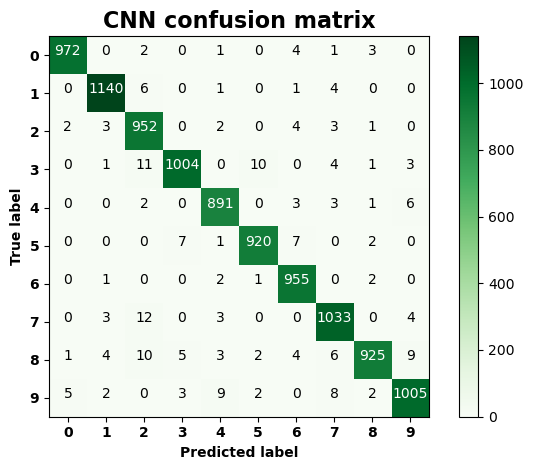

In [22]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, title = 'CNN confusion matrix')

The darker squares in the confusion matrix plot indicate high numbers of cases, and you can hopefully see a diagonal line of darker squares indicating cases where the predicted and actual label are the same.

In the case of a multiclass classification model, a single ROC curve showing true positive rate vs false positive rate is not possible. However, you can use the rates for each class in a One vs Rest (OVR) comparison to create a ROC chart for each class.

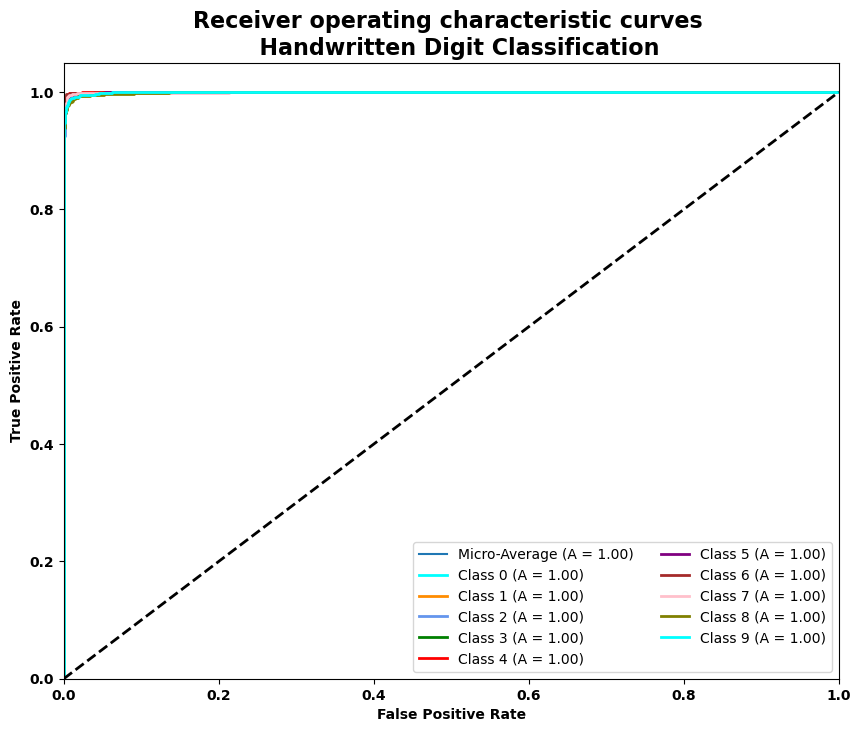

In [23]:

# Binarize the output labels (convert them to one-vs-rest format)
y_true = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_true.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], preds_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area (aggregate of all classes)
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), preds_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class and the micro-average ROC curve
plt.figure(figsize = (10,8))
plt.plot(fpr["micro"], tpr["micro"], 
         label='Micro-Average (A = {0:0.2f})'.format(roc_auc["micro"]))

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'olive', 'cyan']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='Class {0} (A = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight = 'bold')
plt.ylabel('True Positive Rate', fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.title('Receiver operating characteristic curves \n  Handwritten Digit Classification', fontweight = 'bold', fontsize = 16)
plt.legend(loc="lower right", ncol = 2)
plt.show()


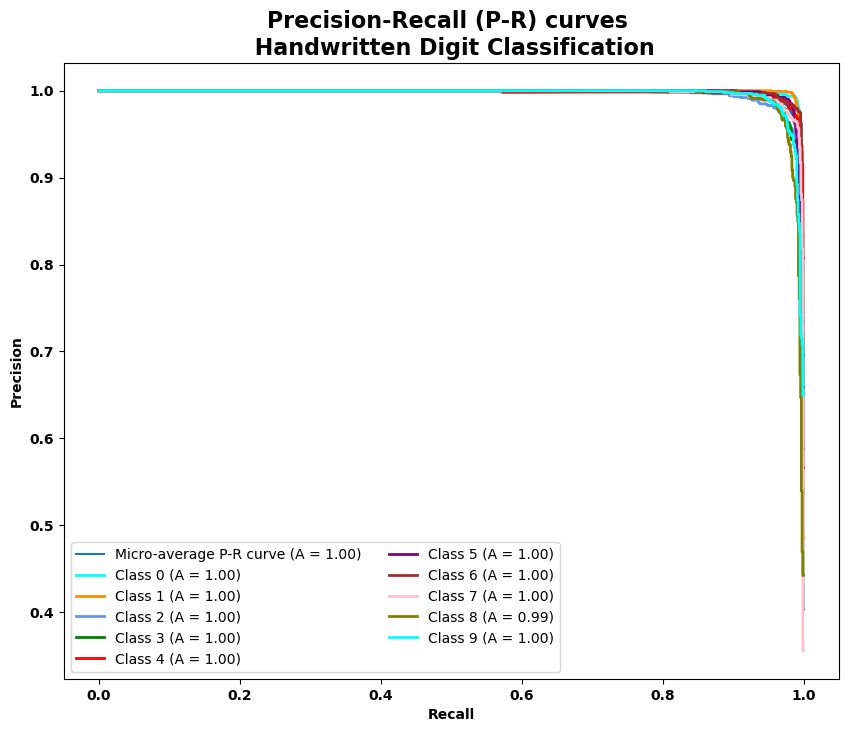

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       0.99      0.99      0.99      1152
           2       0.96      0.98      0.97       967
           3       0.99      0.97      0.98      1034
           4       0.98      0.98      0.98       906
           5       0.98      0.98      0.98       937
           6       0.98      0.99      0.99       961
           7       0.97      0.98      0.98      1055
           8       0.99      0.95      0.97       969
           9       0.98      0.97      0.97      1036

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [24]:
# Compute Precision-Recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()

# Binarize the output labels (convert them to one-vs-rest format for multi-class precision-recall)
y_true = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_true.shape[1]

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], preds_test[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], preds_test[:, i])

# Compute micro-average Precision-Recall curve and average precision score
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), preds_test.ravel())
average_precision["micro"] = average_precision_score(y_true, preds_test, average="micro")

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'olive', 'cyan']
plt.plot(recall["micro"], precision["micro"], label='Micro-average P-R curve (A = {0:0.2f})'
                                                   ''.format(average_precision["micro"]))

for i in range(n_classes):
    plt.plot(recall[i], precision[i], color=colors[i], lw=2,
             label='Class {0} (A = {1:0.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall', fontweight = 'bold')
plt.ylabel('Precision', fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.title('Precision-Recall (P-R) curves \n Handwritten Digit Classification', fontweight = 'bold', fontsize = 16)
plt.legend(loc="lower left", ncol = 2)
plt.show()

# Print classification report for additional insights
print(classification_report(y_test, y_pred))